In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
import random
import torch

# Load STL10 Dataset 13000 witn concatinate Tran&test
> 13k STL10 Dataset Deviation
#70% **train** 20%**val** , 10%**test**


In [2]:


# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

train_transform = transforms.Compose([
    transforms.Resize((64,64)),
#   transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  #for provented to the overfitting
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


# download STL10 dataset (labeled: 5000 train + 8000 test = 13000)
root = "./data"
base_train = datasets.STL10(root=root, split='train', download=True)  # labels available
base_test  = datasets.STL10(root=root, split='test',  download=True)  # labels available

labels_all = np.concatenate([np.array(base_train.labels), np.array(base_test.labels)])  # length = 13000

# split to (70/20/10)
seed = 42
rng = np.random.default_rng(seed)

train_idx, val_idx, test_idx = [], [], []
classes = np.unique(labels_all)

for c in classes:
    idx_c = np.where(labels_all == c)[0]
    rng.shuffle(idx_c)

    n = len(idx_c)
    n_train = int(0.70 * n)
    n_val   = int(0.20 * n)

    train_idx.extend(idx_c[:n_train])
    val_idx.extend(idx_c[n_train:n_train + n_val])
    test_idx.extend(idx_c[n_train + n_val:])

rng.shuffle(train_idx)
rng.shuffle(val_idx)
rng.shuffle(test_idx)

print("Total labeled:", len(labels_all))
print("train/val/test:", len(train_idx), len(val_idx), len(test_idx))

# Concat and Build full_train Dataset with transforms
full_train_tf = ConcatDataset([
    datasets.STL10(root=root, split='train', download=False, transform=train_transform),
    datasets.STL10(root=root, split='test',  download=False, transform=train_transform),
])
# Concat and make full_eval Dataset with transforms
full_eval_tf = ConcatDataset([
    datasets.STL10(root=root, split='train', download=False, transform=val_transform),
    datasets.STL10(root=root, split='test',  download=False, transform=val_transform),
])

training_dataset   = Subset(full_train_tf, train_idx)
validation_dataset = Subset(full_eval_tf,  val_idx)
test_dataset       = Subset(full_eval_tf,  test_idx)

batch_size = 64
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=2, pin_memory=(device.type=='cuda'))
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                               num_workers=2, pin_memory=(device.type=='cuda'))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=(device.type=='cuda'))

print("train size:", len(training_dataset))
print("val size:", len(validation_dataset))
print("test size:", len(test_dataset))
print("len(training_loader):", len(training_loader))
print("len(validation_loader):", len(validation_loader))
print("len(test_loader):", len(test_loader))


device: cuda:0


100%|██████████| 2.64G/2.64G [00:28<00:00, 91.8MB/s]


Total labeled: 13000
train/val/test: 9090 2600 1310
train size: 9090
val size: 2600
test size: 1310
len(training_loader): 143
len(validation_loader): 41
len(test_loader): 21


# Device Selection

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)


device: cuda:0


In [3]:

#tf = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

#train_full = datasets.STL10(root="./data", split="train", download=True, transform=tf)
#test_ds    = datasets.STL10(root="./data", split="test",  download=True, transform=tf)

#print("train_full:", len(train_full))
#print("test_ds:", len(test_ds))
#print("total labeled:", len(train_full)+len(test_ds))


train_full: 5000
test_ds: 8000
total labeled: 13000


# Load Different Layers and Create the Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1))     # (B,256,1,1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),          #Dropout=0.3 for preventing early overfit
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Compiling the Model

In [5]:
net = SimpleCNN(num_classes=10).to(device)
net


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

#Loss Optimizer & Scheduler

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=2e-4, weight_decay=3e-4)    #weight_decay=1e-4 for overfitting provented

## 50%
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2
#)


#Train/Valid Functions

In [7]:
def run_train_epoch(net, loader):
    net.train()
    loss_sum = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        out = net(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0) #for Gradient Clipping
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = torch.argmax(out, dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return loss_sum/total, correct/total


@torch.no_grad()
def run_eval_epoch(net, loader):
    net.eval()
    loss_sum = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        out = net(x)
        loss = criterion(out, y)

        loss_sum += loss.item() * x.size(0)
        pred = torch.argmax(out, dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return loss_sum/total, correct/total


# Train the model *****New train




In [8]:
epochs = 40

running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

# Early Stopping settings
patience = 8
min_delta = 1e-4
best_val_loss = float("inf")
best_epoch = -1
pat_cnt = 0

for e in range(epochs):
    train_loss, train_acc = run_train_epoch(net, training_loader)
    val_loss, val_acc = run_eval_epoch(net, validation_loader)

    ## scheduler (optional) commented for seeing the overfitting
    # scheduler.step(val_loss)

    # store history
    running_loss_history.append(train_loss)
    running_correct_history.append(train_acc)
    val_running_loss_history.append(val_loss)
    val_running_correct_history.append(val_acc)

    print(f"Epoch {e+1:02d} | train loss: {train_loss:.4f} | train acc: {train_acc*100:.2f}%")
    print(f"           | val   loss: {val_loss:.4f} | val   acc: {val_acc*100:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = e + 1
        pat_cnt = 0
        torch.save(net.state_dict(), "best_stl10_cnn.pt")
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("\nEarly stopping activated.")
            break

# load best weights
net.load_state_dict(torch.load("best_stl10_cnn.pt", map_location=device))
print("\nBest epoch:", best_epoch, "| best val_loss:", best_val_loss)

    #{
          # Stop training after epoch = best_epoch in this stage epoch 28
          # Reason: validation loss is minimum at best_epoch. After that, it did not improve for 'patience' epochs,
          # so continuing training is likely to overfit and hurt validation performance.
    #}



Epoch 01 | train loss: 1.7415 | train acc: 35.03%
           | val   loss: 1.5764 | val   acc: 40.62%
Epoch 02 | train loss: 1.5126 | train acc: 44.06%
           | val   loss: 1.4498 | val   acc: 46.08%
Epoch 03 | train loss: 1.3985 | train acc: 49.25%
           | val   loss: 1.3630 | val   acc: 49.35%
Epoch 04 | train loss: 1.3208 | train acc: 52.35%
           | val   loss: 1.2767 | val   acc: 52.85%
Epoch 05 | train loss: 1.2604 | train acc: 54.87%
           | val   loss: 1.3131 | val   acc: 52.42%
Epoch 06 | train loss: 1.2058 | train acc: 57.03%
           | val   loss: 1.1972 | val   acc: 55.19%
Epoch 07 | train loss: 1.1691 | train acc: 58.49%
           | val   loss: 1.1520 | val   acc: 57.96%
Epoch 08 | train loss: 1.1257 | train acc: 60.12%
           | val   loss: 1.1654 | val   acc: 57.65%
Epoch 09 | train loss: 1.1008 | train acc: 60.98%
           | val   loss: 1.2419 | val   acc: 55.42%
Epoch 10 | train loss: 1.0723 | train acc: 62.43%
           | val   loss: 1.1334 

# Plot Learning Curve

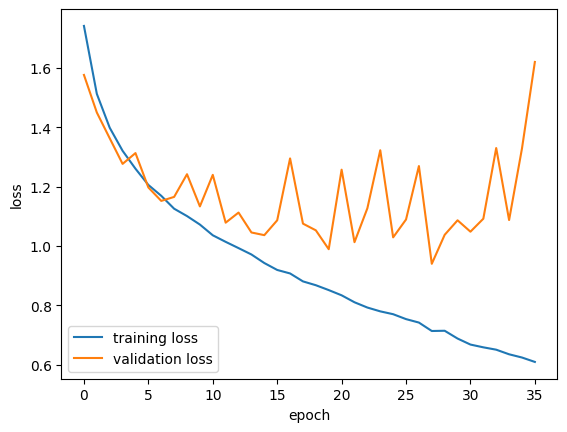

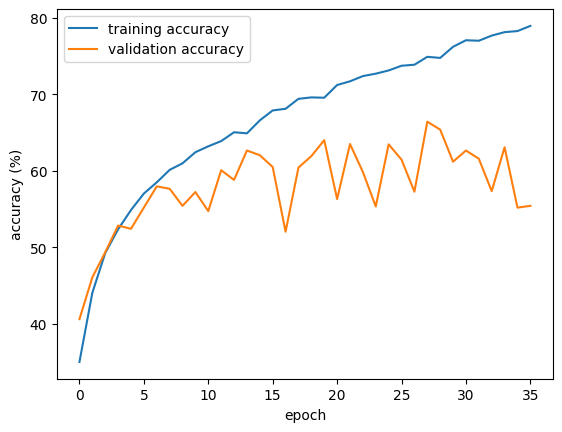

Best epoch (stop here): 28
Validation accuracy at best epoch: 66.42307692307692 %


In [12]:
plt.figure()
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.plot([a*100 for a in running_correct_history], label='training accuracy')
plt.plot([a*100 for a in val_running_correct_history], label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.legend()
plt.show()

print("Best epoch (stop here):", best_epoch)
print("Validation accuracy at best epoch:", val_running_correct_history[best_epoch-1]*100, "%")
# Stop after epoch = best_epoch
# Reason: validation loss stopped improving; continuing training would likely overfit.

#Test Evaluation(extra for me)

In [13]:
test_loss, test_acc = run_eval_epoch(net, test_loader)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100:.2f}%")


Test loss: 0.9726 | Test acc: 66.11%
